In [127]:
import cv2 as cv
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import multiprocessing as mp
import numpy as np
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import scipy as sp
import seaborn as sns
import sys
import time
import timeit

In [106]:
HEMNET_PREDICTIONS_PATH = Path('/gpfs1/scratch/90days/s4436005/TCGA/02_08_20/Slide_Predictions.csv')
TUMOUR_PURITY_PATH = Path('/gpfs1/scratch/90days/s4436005/TCGA/COAD_tumor_purity.txt')

In [107]:
hemnet_predictions = pd.read_csv(HEMNET_PREDICTIONS_PATH, index_col = 0)
tumour_purity = pd.read_csv(TUMOUR_PURITY_PATH, sep = '\t')

In [108]:
hemnet_predictions.shape

(32, 7)

In [109]:
hemnet_ids = [x.split('-')[1:4] for x in hemnet_predictions.index.values]
hemnet_ids = [f'{x}-{y}-{z}' for x,y,z in hemnet_ids]
hemnet_ids

['D5-6928-01A',
 'CK-5913-01A',
 'AA-3663-01A',
 'AZ-5403-01A',
 'F4-6856-01Z',
 'AZ-4682-01B',
 'AD-6889-01Z',
 'G4-6307-01Z',
 'AA-3663-11A',
 'G4-6307-01A',
 'A6-6650-01B',
 'AZ-4615-01A',
 'DM-A280-01A',
 'CM-6677-01Z',
 'G4-6322-01A',
 'AA-3663-01A',
 'D5-5537-01Z',
 'G4-6307-01A',
 'CM-6677-01A',
 'A6-5656-01A',
 'AZ-5403-01A',
 'CK-5913-01Z',
 'CK-5914-01Z',
 'AA-3492-01A',
 'A6-5656-01B',
 'DM-A0XD-01A',
 'AZ-5403-01Z',
 'CK-6747-01A',
 'CK-6747-01Z',
 'F4-6856-01A',
 'A6-5656-01Z',
 'F4-6856-01A']

In [110]:
hemnet_predictions = hemnet_predictions.reset_index()
hemnet_predictions['ID'] = hemnet_ids
hemnet_predictions = hemnet_predictions.set_index('ID')
hemnet_predictions.head()

,index,Slide_Name,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion
ID,,,,,,,,
D5-6928-01A,TCGA-D5-6928-01A-01-BS1,TCGA-D5-6928-01A-01-BS1.9e649367-15d6-40f4-8c7...,1056,513,0.485795,0.488634,0.542203,0.556730
CK-5913-01A,TCGA-CK-5913-01A-01-TS1,TCGA-CK-5913-01A-01-TS1.d2ffb454-f0de-4538-953...,329,186,0.565350,0.547186,0.626114,0.660578
AA-3663-01A,TCGA-AA-3663-01A-01-BS1,TCGA-AA-3663-01A-01-BS1.29369de3-d3c2-4712-a8d...,708,318,0.449153,0.453151,0.570414,0.610484
AZ-5403-01A,TCGA-AZ-5403-01A-01-TS1,TCGA-AZ-5403-01A-01-TS1.52f83f14-e748-4607-a3c...,1189,665,0.559294,0.538785,0.652156,0.730080
F4-6856-01Z,TCGA-F4-6856-01Z-00-DX1,TCGA-F4-6856-01Z-00-DX1.2872c7b5-b94d-4147-ad9...,5031,401,0.079706,0.111177,0.117843,0.090973


In [111]:
# Check if all index values are unique
hemnet_predictions.index.is_unique

False

In [112]:
hemnet_predictions = hemnet_predictions.groupby(['ID']).mean()

In [113]:
# Check if all index values are unique
hemnet_predictions.index.is_unique

True

In [114]:
tumour_purity.head()

,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,-
1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,-
2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [115]:
# Replace dash with NaN
tumour_purity = tumour_purity.replace('-', np.nan)
tumour_purity.head()

,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,NaN
1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,NaN
2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [116]:
tumour_purity['Purity_ABSOLUTE'] = tumour_purity['Purity_ABSOLUTE'].astype(np.float64)
tumour_purity.dtypes

#Sample ID          object
Cancer type         object
ESTIMATE           float64
ABSOLUTE           float64
LUMP               float64
IHC                float64
CPE                float64
num_subpop         float64
expands            float64
infinium           float64
Purity_ABSOLUTE    float64
dtype: object

In [117]:
tumour_purity_ids = [x.split('-')[1:4] for x in tumour_purity['#Sample ID'].values]
tumour_purity_ids = [f'{x}-{y}-{z}' for x,y,z in tumour_purity_ids]
tumour_purity_ids

['3L-AA1B-01A',
 '4N-A93T-01A',
 '4T-AA8H-01A',
 '5M-AAT4-01A',
 '5M-AAT5-01A',
 '5M-AAT6-01A',
 '5M-AATA-01A',
 '5M-AATE-01A',
 'A6-2670-01A',
 'A6-2671-01A',
 'A6-2672-01A',
 'A6-2674-01A',
 'A6-2674-01B',
 'A6-2675-01A',
 'A6-2676-01A',
 'A6-2677-01A',
 'A6-2677-01B',
 'A6-2678-01A',
 'A6-2679-01A',
 'A6-2680-01A',
 'A6-2681-01A',
 'A6-2682-01A',
 'A6-2683-01A',
 'A6-2684-01A',
 'A6-2684-01C',
 'A6-2685-01A',
 'A6-2686-01A',
 'A6-3807-01A',
 'A6-3808-01A',
 'A6-3809-01A',
 'A6-3809-01B',
 'A6-3810-01A',
 'A6-3810-01B',
 'A6-4105-01A',
 'A6-4107-01A',
 'A6-5656-01A',
 'A6-5656-01B',
 'A6-5657-01A',
 'A6-5659-01A',
 'A6-5659-01B',
 'A6-5660-01A',
 'A6-5661-01A',
 'A6-5661-01B',
 'A6-5662-01A',
 'A6-5664-01A',
 'A6-5665-01A',
 'A6-5665-01B',
 'A6-5666-01A',
 'A6-5667-01A',
 'A6-6137-01A',
 'A6-6138-01A',
 'A6-6140-01A',
 'A6-6141-01A',
 'A6-6142-01A',
 'A6-6648-01A',
 'A6-6649-01A',
 'A6-6650-01A',
 'A6-6650-01B',
 'A6-6651-01A',
 'A6-6652-01A',
 'A6-6653-01A',
 'A6-6654-01A',
 'A6-678

In [118]:
tumour_purity = tumour_purity.reset_index()
tumour_purity['ID'] = tumour_purity_ids
tumour_purity = tumour_purity.set_index('ID')
tumour_purity.head()

,index,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
ID,,,,,,,,,,,,
3L-AA1B-01A,0,TCGA-3L-AA1B-01A,COAD,0.9025,NaN,0.6238,0.70,0.7913,4.0,0.445976,0.53,NaN
4N-A93T-01A,1,TCGA-4N-A93T-01A,COAD,0.9752,NaN,0.7915,0.75,0.7898,4.0,0.957717,0.75,NaN
4T-AA8H-01A,2,TCGA-4T-AA8H-01A,COAD,0.9865,NaN,NaN,0.60,0.8917,4.0,0.495473,NaN,NaN
5M-AAT4-01A,3,TCGA-5M-AAT4-01A,COAD,0.9720,NaN,NaN,0.70,0.8372,8.0,0.954421,NaN,NaN
5M-AAT5-01A,4,TCGA-5M-AAT5-01A,COAD,0.9752,NaN,NaN,0.75,0.8170,NaN,NaN,NaN,NaN


In [64]:
tumour_purity.columns.values

array(['index', '#Sample ID', 'Cancer type', 'ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE'], dtype=object)

In [13]:
tumour_purity.shape

(476, 12)

In [42]:
tumour_purity.index.is_unique

True

In [44]:
hemnet_predictions.index.drop_duplicates()

Index(['D5-6928-01A', 'CK-5913-01A', 'AA-3663-01A', 'AZ-5403-01A',
       'F4-6856-01Z', 'AZ-4682-01B', 'AD-6889-01Z', 'G4-6307-01Z',
       'AA-3663-11A', 'G4-6307-01A', 'A6-6650-01B', 'AZ-4615-01A',
       'DM-A280-01A', 'CM-6677-01Z', 'G4-6322-01A', 'D5-5537-01Z',
       'CM-6677-01A', 'A6-5656-01A', 'CK-5913-01Z', 'CK-5914-01Z',
       'AA-3492-01A', 'A6-5656-01B', 'DM-A0XD-01A', 'AZ-5403-01Z',
       'CK-6747-01A', 'CK-6747-01Z', 'F4-6856-01A', 'A6-5656-01Z'],
      dtype='object', name='ID')

In [25]:
tumour_purity.index.drop_duplicates()

Index(['3L-AA1B', '4N-A93T', '4T-AA8H', '5M-AAT4', '5M-AAT5', '5M-AAT6',
       '5M-AATA', '5M-AATE', 'A6-2670', 'A6-2671',
       ...
       'QG-A5YV', 'QG-A5YW', 'QG-A5YX', 'QG-A5Z1', 'QG-A5Z2', 'QL-A97D',
       'RU-A8FL', 'SS-A7HO', 'T9-A92H', 'WS-AB45'],
      dtype='object', name='ID', length=462)

In [22]:
hemnet_predictions = hemnet_predictions.loc[hemnet_predictions.index.drop_duplicates()]
tumour_purity = tumour_purity.loc[tumour_purity.index.drop_duplicates()]

In [29]:
hemnet_predictions.shape

(32, 8)

In [119]:
combined = pd.concat([hemnet_predictions, tumour_purity], axis = 1, join='inner')

In [120]:
combined

,Tiles,Cancer_Tiles,Cancer_Tile_Proportion,Average_Sigmoid_Value,Weighted_Average_Sigmoid_Value,Cancer_Area_Proportion,index,#Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,num_subpop,expands,infinium,Purity_ABSOLUTE
ID,,,,,,,,,,,,,,,,,,
A6-5656-01A,535.0,310.0,0.579439,0.554010,0.590436,0.630125,35,TCGA-A6-5656-01A,COAD,0.9606,0.81,0.8236,0.8022,0.7000,3.0,0.879379,0.63,NaN
A6-5656-01B,446.0,22.0,0.049327,0.104853,0.591266,0.614253,36,TCGA-A6-5656-01B,COAD,NaN,NaN,0.7234,0.6250,0.7282,3.0,0.879379,0.63,NaN
A6-6650-01B,611.0,507.0,0.829787,0.824598,0.889291,0.901478,57,TCGA-A6-6650-01B,COAD,NaN,NaN,0.7804,0.9200,0.7393,5.0,0.997606,0.71,NaN
AA-3492-01A,680.0,483.0,0.710294,0.678057,0.871515,0.927338,74,TCGA-AA-3492-01A,COAD,0.8819,0.82,0.8096,0.7250,0.8306,10.0,0.884577,0.73,0.82
AA-3663-01A,514.5,269.5,0.568813,0.556101,0.680305,0.732981,118,TCGA-AA-3663-01A,COAD,0.9107,0.79,0.8441,0.7000,0.8893,10.0,0.827597,0.70,NaN
AZ-4615-01A,1403.0,794.0,0.565930,0.560223,0.650222,0.675528,278,TCGA-AZ-4615-01A,COAD,0.7739,0.67,0.7129,0.7500,0.7509,5.0,0.775833,0.56,0.67
AZ-4682-01B,1146.0,617.0,0.538394,0.525697,0.586041,0.621916,281,TCGA-AZ-4682-01B,COAD,0.9415,0.78,0.8272,0.7250,0.8671,1.0,0.917527,0.74,NaN
AZ-5403-01A,1038.5,593.0,0.573003,0.543328,0.626851,0.698719,283,TCGA-AZ-5403-01A,COAD,0.8700,0.38,0.7107,0.7500,0.7542,3.0,0.938637,0.50,NaN
CK-5913-01A,329.0,186.0,0.565350,0.547186,0.626114,0.660578,310,TCGA-CK-5913-01A,COAD,0.8486,0.71,0.7184,0.8000,0.7758,5.0,0.720724,0.67,NaN


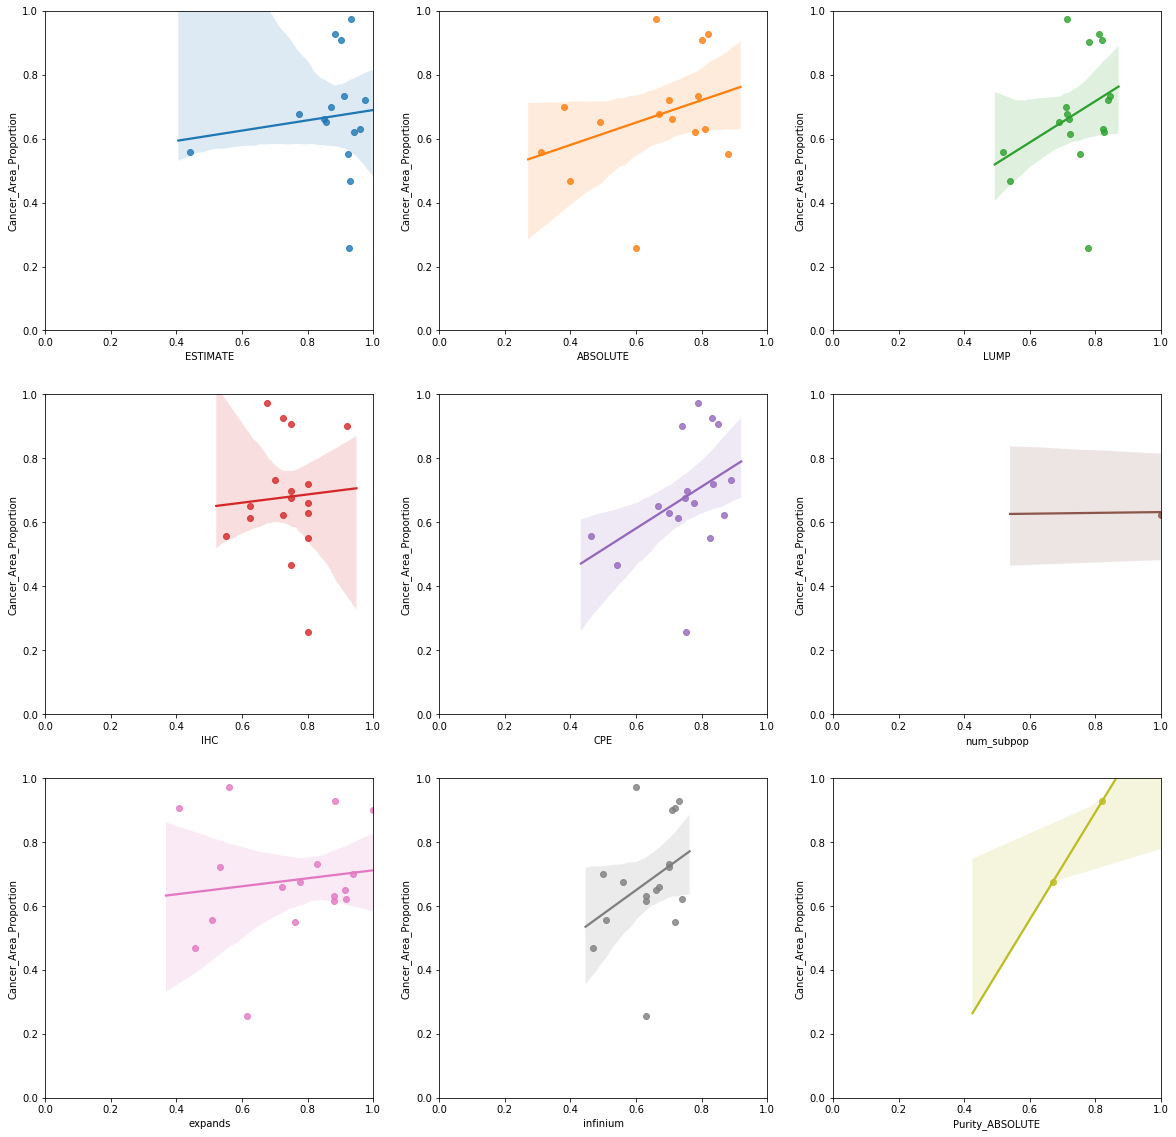

In [122]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
for i, ax in enumerate(axs.ravel()):
    sns.regplot(x = columns[i], y = 'Cancer_Area_Proportion', ci = 95, data = combined, ax = ax)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)

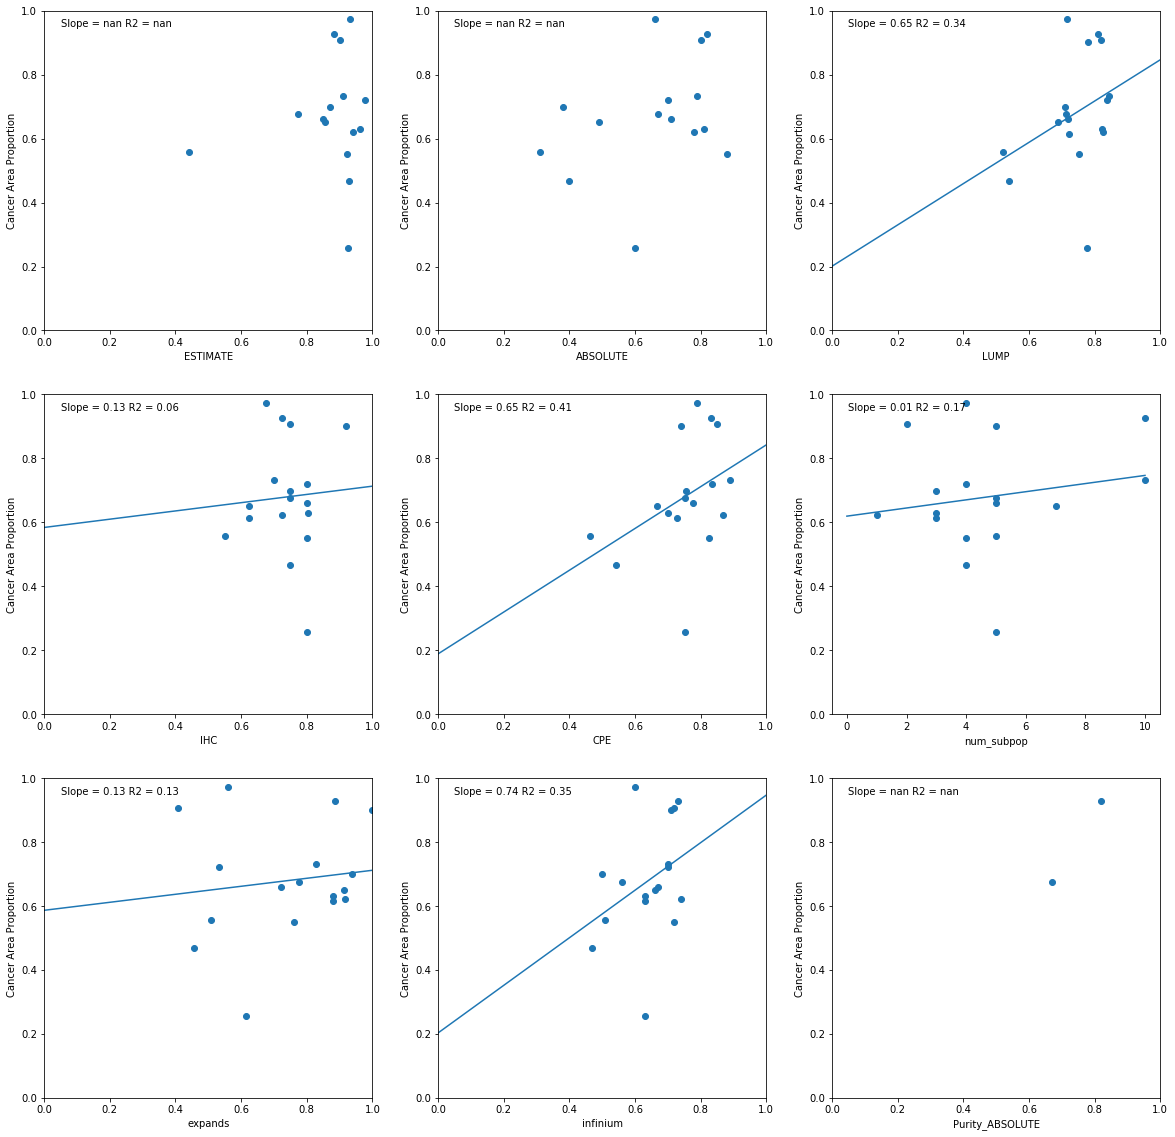

In [162]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (20,20))

columns = ['ESTIMATE', 'ABSOLUTE',
       'LUMP', 'IHC', 'CPE', 'num_subpop', 'expands', 'infinium',
       'Purity_ABSOLUTE']
y_values = combined['Cancer_Area_Proportion'].values
# y_values = combined['Weighted_Average_Sigmoid_Value'].values
for i, ax in enumerate(axs.ravel()):
    x_values = combined[columns[i]].values
    ax.scatter(x = x_values , y = y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,10, 50), linreg.intercept + linreg.slope * np.linspace(0,10, 50))
    ax.text(0.05 , 0.95 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f}')
#     print(x_values)
    ax.set_xlabel(columns[i], fontsize = 10)
    ax.set_ylabel('Cancer Area Proportion', fontsize = 10)
    ax.set_ylim(0,1)
    if columns[i] != 'num_subpop':
        ax.set_xlim(0,1)
#fig.tight_layout()